In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")
print(f"How many devices {torch.cuda.device_count()}")

True
cuda
Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device: NVIDIA GeForce RTX 4060
How many devices 1


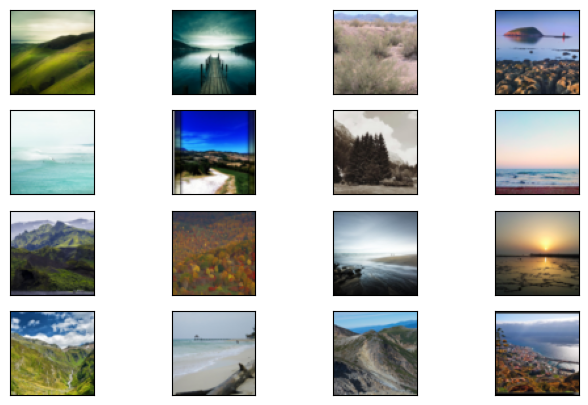

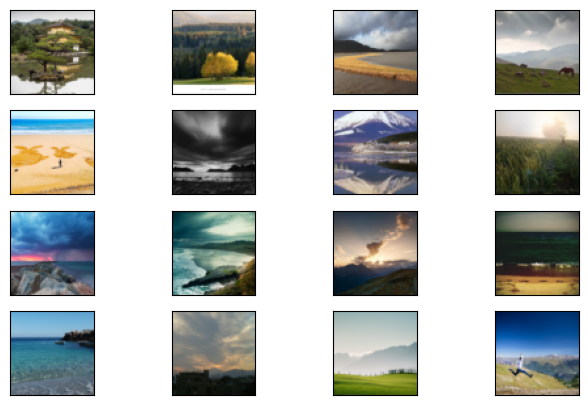

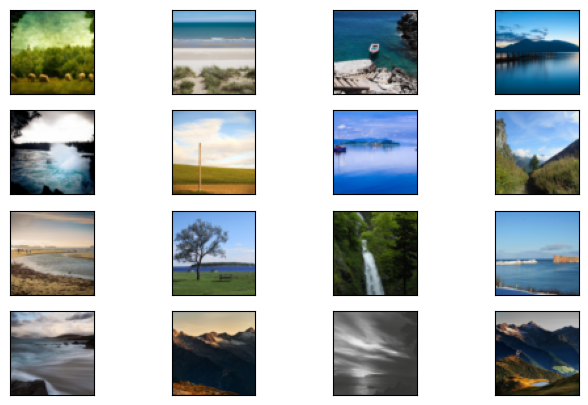

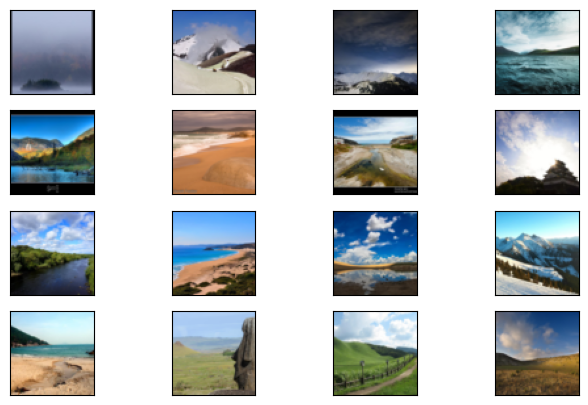

In [5]:
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                ])
y = datasets.ImageFolder('./data/', transform=transform)

y_dataloader = torch.utils.data.DataLoader(y,
                                           batch_size=16,
                                           shuffle=False)
y_batched_data = iter(y_dataloader)
batch = 0
for e, (real, _) in enumerate(y_dataloader):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 5),  #Размер вывода
                             subplot_kw={'xticks': [], 'yticks': []})
    img_indx = 0
    for i, ax in enumerate(axes):
        for count in range(4):
            ax[count].imshow(real[img_indx].detach().numpy().transpose((1, 2, 0)))
            img_indx += 1
    batch += 1
    if batch == 4:
        break

In [8]:
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                #transforms.Grayscale(num_output_channels=1),
                                transforms.Normalize(mean=0.5, std=0.5),
                                ])
y = datasets.ImageFolder('./data/', transform=transform)
y_dataloader = torch.utils.data.DataLoader(y,
                                           batch_size=150,
                                           shuffle=True)


class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=1024, stride=1, kernel_size=4, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(inplace=True), )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, stride=2, kernel_size=4, padding=1, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True), )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, stride=2, kernel_size=4, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True), )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, stride=2, kernel_size=4, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True), )
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=3, stride=2, kernel_size=4, padding=1, bias=False),
            nn.Tanh())

        # self.fc1 = torch.nn.Linear(512, 1024)
        # self.ac5 = torch.nn.LeakyReLU()
        # self.fc2 = torch.nn.Linear(1024, 2048)
        # self.ac6 = torch.nn.LeakyReLU()
        # self.fc3 = torch.nn.Linear(2048, 3 * 64 * 64)
        # self.ac_end = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1, 1))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 3, 64, 64)
        # x = self.fc1(x)
        # x = self.ac5(x)
        # x = self.fc2(x)
        # x = self.ac6(x)
        # x = self.fc3(x)
        # x = self.ac_end(x)
        # x = x.view(-1, 3, 64, 64)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, stride=2, kernel_size=5, padding=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=128, out_channels=256, stride=2, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2, inplace=True), )
        # nn.BatchNorm1d(512))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, stride=2, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2, inplace=True), )
        #nn.BatchNorm1d(128))
        self.output = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, stride=2, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(num_features=1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=1, stride=4, kernel_size=5, padding=1, bias=False),
            nn.Sigmoid())

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x.reshape((x.shape[0], 1))


D = Discriminator().to(device)
I = Generator().to(device)
loss = nn.BCELoss()

D.train()
I.train()

D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)  #torch.optim.SGD(D.parameters(), lr=0.003)
I_optimizer = torch.optim.Adam(I.parameters(), lr=0.0003)
for e in range(300):
    for i, (real, _) in enumerate(y_dataloader):
        noise = (torch.rand(real.shape[0], 100).to(device) - 0.5) / 0.5
        I_img = I(noise)
        D_I_pred = D(I_img)
        I_loss = loss(D_I_pred, torch.ones_like(D_I_pred))
        I_optimizer.zero_grad()
        I_loss.backward(retain_graph=True)
        I_optimizer.step()

        noise = (torch.rand(real.shape[0], 100).to(device) - 0.5) / 0.5
        real = real.to(device)
        I_img = I(noise)
        D_I_pred = D(I_img)
        D_real_pred = D(real)
        D_I_loss = loss(D_I_pred, torch.zeros_like(D_I_pred))
        D_real_loss = loss(D_real_pred, torch.ones_like(D_real_pred))
        D_loss = ((D_I_loss + D_real_loss) / 2).mean()
        D_optimizer.zero_grad()
        D_loss.backward(retain_graph=True)
        D_optimizer.step()

        if i % 100 == 0 or i == len(y_dataloader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(e, i, D_loss.item(),
                                                                                                  I_loss.item()))
        print(D_loss.item(), I_loss.item())
    if (e + 1) % 2 == 0:
        torch.save(I, './models_weights/Generator_epoch_{}.pth'.format(e))
        print('Model saved.')

Epoch 0 Iteration 0: discriminator_loss 1.880 generator_loss 0.931
1.879889726638794 0.9311124086380005
0.33756422996520996 16.338626861572266
2.351764678955078 11.686668395996094
0.13475503027439117 16.54469108581543
0.03988175094127655 17.26795768737793
0.07541944086551666 17.107152938842773
0.0306865181773901 16.46648406982422
0.02989942394196987 15.30337905883789
0.016746267676353455 12.51285171508789
4.8149733543396 5.967785835266113
0.013166498392820358 12.098265647888184
0.033183395862579346 14.1244535446167
0.10895607620477676 14.703180313110352
0.1064329668879509 14.540059089660645
0.06319349259138107 13.847041130065918
0.04628242552280426 12.278646469116211
1.5274125337600708 7.405056953430176
0.09827905893325806 9.39509105682373
0.07522600889205933 11.064534187316895
0.059474676847457886 11.39758014678955
0.0532054677605629 11.041375160217285
0.05995521321892738 10.375091552734375
0.027922265231609344 9.660107612609863
0.03719385713338852 8.7391357421875
0.018146254122257233

KeyboardInterrupt: 

In [10]:
torch.save(I, './models_weights/Generator_saved240.pth')
torch.save(D, './models_weights/Discriminator_saved240.pth')